In [112]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from collections import Counter
import warnings

warnings.filterwarnings('ignore')

In [113]:
logs = pd.read_csv('./API Logs.log', delimiter=' ', header=0)
df = logs[['cs-method', 'cs-uri-stem', 's-port', 'sc-status', 'sc-bytes', 'cs-bytes', 'time-taken']]
df['year'] = pd.to_datetime(logs['date']).dt.year
df['month'] = pd.to_datetime(logs['date']).dt.month
df['day'] = pd.to_datetime(logs['date']).dt.day
df['hour'] = pd.to_datetime(logs['time']).dt.hour
df['minute'] = pd.to_datetime(logs['time']).dt.minute
df.head()

,cs-method,cs-uri-stem,s-port,sc-status,sc-bytes,cs-bytes,time-taken,year,month,day,hour,minute
0,GET,/api/values,8080,200,278,299,1167,2023,11,9,18,4
1,GET,/api/values,8080,200,278,299,1,2023,11,9,18,4
2,GET,/api/values,8080,500,4796,299,212,2023,11,22,7,28
3,GET,/api/values,8080,200,278,299,12737,2023,11,22,7,30
4,GET,/api/values/1,8080,200,265,301,66,2023,11,22,7,30


In [114]:
unique_sc_status = df['sc-status'].unique()
unique_sc_status = unique_sc_status[unique_sc_status != 200]
print("Status: ",unique_sc_status)

Status:  [500 204 405 400 415]


In [115]:
data = df[df['time-taken'] > 1000]
unique_data = data['sc-status'].unique()
unique_data = unique_data[unique_data!=200]
for status in unique_data:
    filtered_data = data[data['sc-status'] == status]
    print(status,": ",filtered_data.shape)

405 :  (1, 12)
400 :  (3, 12)
500 :  (1027, 12)


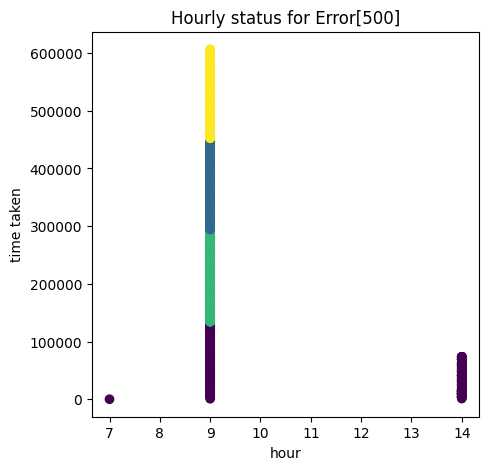

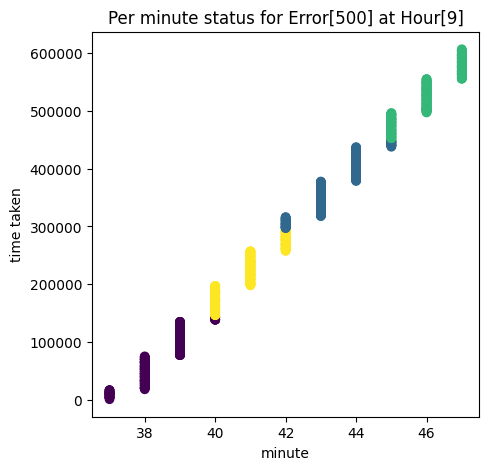

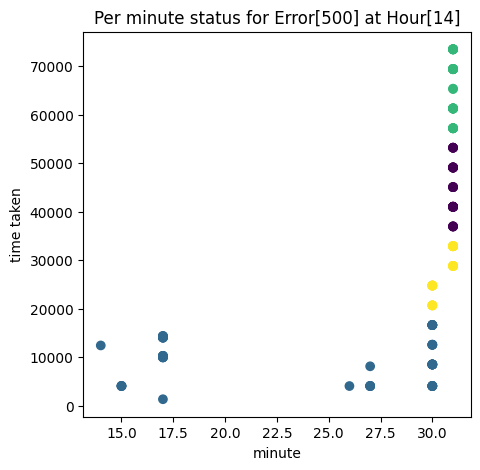

In [122]:
min_no_of_errors = 25
time_taken = 1000
for status in unique_sc_status:
    filtered_df = df[df['sc-status'] == status]
    df_encoded = pd.get_dummies(filtered_df)
    if(filtered_df[filtered_df['time-taken'] > time_taken].shape[0]>min_no_of_errors):
        for k in range(2, 5):
            kmeans = KMeans(n_clusters=k, random_state=1)
            kmeans.fit(df_encoded)
        labels = kmeans.labels_
        plt.figure(figsize=(5, 5))
        plt.scatter(df_encoded['hour'], df_encoded['time-taken'], c=labels)
        plt.xlabel('hour')
        plt.ylabel('time taken')
        plt.title("Hourly status for Error["+str(status)+"]")
        plt.show()

        hours = filtered_df['hour'].value_counts()[filtered_df['hour'].value_counts() > min_no_of_errors].index.tolist()
        for hour in hours:
            df_hourly = df_encoded[df_encoded['hour'] == hour]
            if(df_hourly.shape[0]>min_no_of_errors):
                for k in range(2, 5):
                    kmeans = KMeans(n_clusters=k, random_state=1)
                    kmeans.fit(df_hourly)
                labels = kmeans.labels_
                plt.figure(figsize=(5, 5))
                plt.scatter(df_hourly['minute'], df_hourly['time-taken'], c=labels)
                plt.xlabel('minute')
                plt.ylabel('time taken')
                plt.title("Per minute status for Error["+str(status)+"] at Hour["+str(hour)+"]" )
                plt.show()